In [1]:
import pandas as pd

# Load the Excel file
file_path = "All Data.xlsx"
data = pd.read_excel(file_path)

# Display the first few rows of the file
print(data.head())

          DisNo. Historic Classification Key Disaster Group Disaster Subgroup  \
0  1900-0003-USA      Yes    nat-met-sto-tro        Natural    Meteorological   
1  1900-0006-JAM      Yes    nat-hyd-flo-flo        Natural      Hydrological   
2  1900-0007-JAM      Yes    nat-bio-epi-vir        Natural        Biological   
3  1900-0008-JPN      Yes    nat-geo-vol-ash        Natural       Geophysical   
4  1900-0009-TUR      Yes    nat-geo-ear-gro        Natural       Geophysical   

       Disaster Type  Disaster Subtype External IDs       Event Name  ISO  \
0              Storm  Tropical cyclone          NaN              NaN  USA   
1              Flood   Flood (General)          NaN              NaN  JAM   
2           Epidemic     Viral disease          NaN  Gastroenteritis  JAM   
3  Volcanic activity          Ash fall          NaN              NaN  JPN   
4         Earthquake   Ground movement          NaN              NaN  TUR   

   ... Reconstruction Costs ('000 US$)  \
0  ...  

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Replace NaN values in Start Month and Start Day with 1
data['Start Month'].fillna(1, inplace=True)
data['Start Day'].fillna(1, inplace=True)

data['Date'] = data['Start Year'].astype(str) + '-' + data['Start Month'].astype(int).astype(str).str.zfill(2) + '-' + data['Start Day'].astype(int).astype(str).str.zfill(2)

# Convert the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

C:\Users\milan\AppData\Local\Temp\ipykernel_21676\3392825531.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Start Month'].fillna(1, inplace=True)
C:\Users\milan\AppData\Local\Temp\ipykernel_21676\3392825531.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [ ]:
# Filter for extreme weather events
extreme_weather_events = ['Flood', 'Storm', 'Drought', 'Extreme temperature', 'Wildfire']
weather_data = data[data['Disaster Type'].isin(extreme_weather_events)]

# Extract relevant columns: Start Year, Start Month, Start Day, and economic cost column
economic_column = "Total Damage, Adjusted ('000 US$)"
weather_data = weather_data[['Date', economic_column]]

weather_data[economic_column] = weather_data[economic_column] * 1000
weather_data.dropna(subset=[economic_column], inplace=True)

In [5]:
# Rename the column by removing ' ('000 US$)' and add three zeros for scaling
weather_data.rename(columns={"Total Damage, Adjusted ('000 US$)": "Total Damage Adjusted"}, inplace=True)

In [ ]:
# Convert Date column to datetime if it's not already in datetime format
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Aggregate total damage adjusted per year 
weather_data['Year'] = weather_data['Date'].dt.year
total_costs_per_year = weather_data.groupby('Year')['Total Damage Adjusted'].sum().reset_index()

# Remove NaN values
total_costs_per_year = total_costs_per_year.dropna()

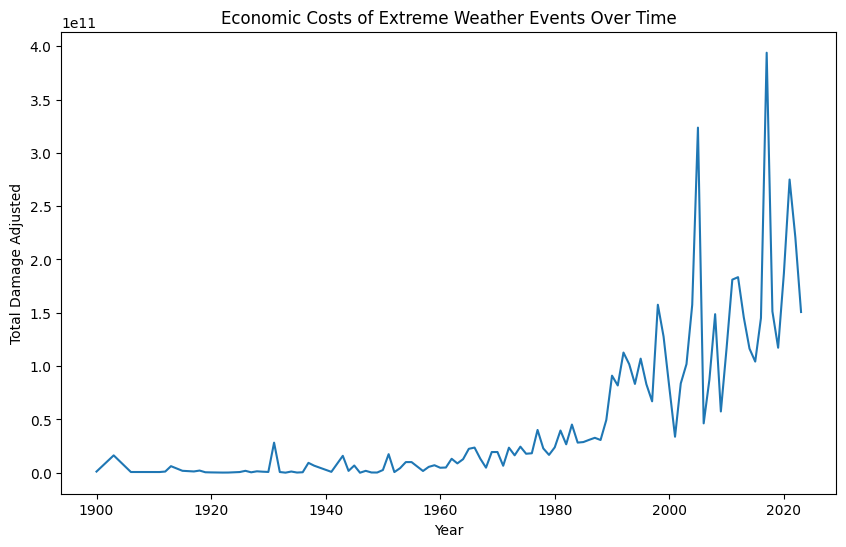

In [7]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Year', y='Total Damage Adjusted', data=total_costs_per_year)
plt.title("Economic Costs of Extreme Weather Events Over Time")
plt.xlabel("Year")
plt.ylabel("Total Damage Adjusted")
plt.show()


Total Damage, Adjusted

In [8]:
from scipy.stats import linregress


Slope: 1593108591.2493424
Intercept: -3084423632611.4844
R-squared: 0.5436381153392841
P-value: 9.134620458673117e-20


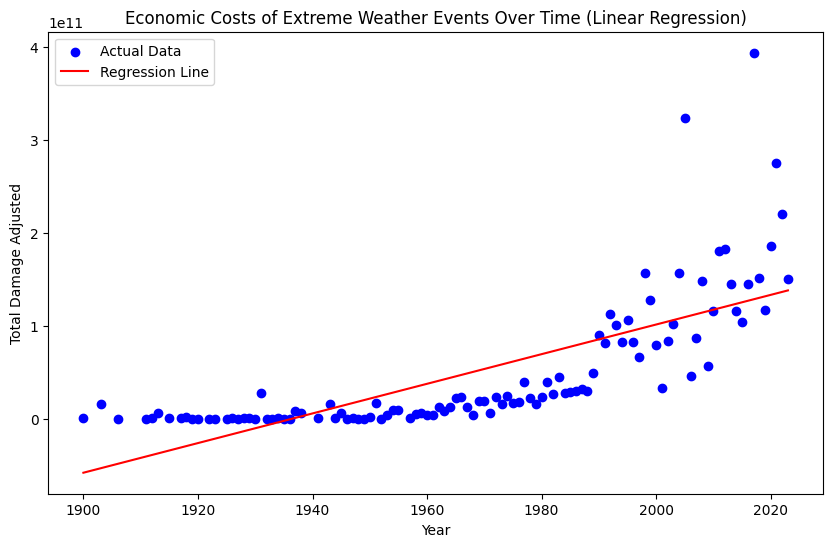

In [ ]:
# Define the independent (x) and dependent (y) variables
x = total_costs_per_year['Year'].values  
y = total_costs_per_year['Total Damage Adjusted'].values  

# Perform the regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Output the results of the regression
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

plt.figure(figsize=(10, 6))

plt.scatter(x, y, color='blue', label='Actual Data')
plt.plot(x, slope * x + intercept, color='red', label='Regression Line')
plt.title("Economic Costs of Extreme Weather Events Over Time (Linear Regression)")
plt.xlabel("Year")
plt.ylabel("Total Damage Adjusted")
plt.legend()
plt.show()



Durbin-Watson statistic: 1.18
(Values < 1.5 suggest positive autocorrelation, > 2.5 suggest negative autocorrelation)


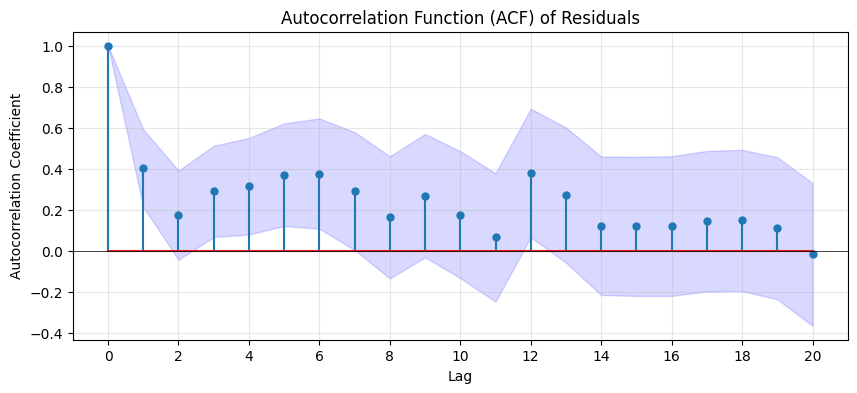


Using 4 lags for Newey-West HAC estimation

Standard Error Comparison:
                   OLS SE           NW SE  Ratio (OLS/NW)
Intercept 279027691131.10 477434563910.22            0.58
Slope        141772559.64    243621404.55            0.58

Breusch-Godfrey Test for Autocorrelation:
LM Statistic: 26.79, p-value: 0.0000


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf


X = sm.add_constant(x) 
model = sm.OLS(y, X).fit()

# Durbin-Watson test for autocorrelation
dw = durbin_watson(model.resid)
print(f"\nDurbin-Watson statistic: {dw:.2f}")
print("(Values < 1.5 suggest positive autocorrelation, > 2.5 suggest negative autocorrelation)")

plt.figure(figsize=(10, 4))
acf_values, confint = acf(model.resid, nlags=20, alpha=0.05, fft=False)

# Create stem plot with confidence intervals
markerline, stemline, baseline = plt.stem(acf_values, linefmt='C0-', markerfmt='C0o')
plt.setp(stemline, linewidth=1.5)
plt.setp(markerline, markersize=5)
plt.fill_between(np.arange(len(confint)), 
                 confint[:,0], confint[:,1],
                 color='blue', alpha=0.15)

plt.axhline(0, color='black', linewidth=0.5)
plt.title("Autocorrelation Function (ACF) of Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation Coefficient")
plt.xticks(np.arange(0, 21, 2))
plt.grid(alpha=0.3)
plt.show()

# Newey-West HAC standard errors with improved lag selection
nobs = len(y)
lag = int(np.floor(4 * (nobs/100) ** (2/9)))  

print(f"\nUsing {lag} lags for Newey-West HAC estimation")
model_hac = model.get_robustcov_results(cov_type='HAC', maxlags=lag) 

results_df = pd.DataFrame({
    'OLS SE': model.bse.round(2),
    'NW SE': model_hac.bse.round(2),
    'Ratio (OLS/NW)': (model.bse/model_hac.bse).round(2)
}, index=['Intercept', 'Slope'])

print("\nStandard Error Comparison:")
print(results_df.to_string(float_format=lambda x: f"{x:.2f}"))

print("\nBreusch-Godfrey Test for Autocorrelation:")
bg_test = sm.stats.diagnostic.acorr_breusch_godfrey(model, nlags=lag)
print(f"LM Statistic: {bg_test[0]:.2f}, p-value: {bg_test[1]:.4f}")

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

ts_data = total_costs_per_year['Insured Damage, Adjusted'].dropna()

adf_result = adfuller(ts_data, autolag='AIC')
print("""
Augmented Dickey-Fuller Test Results:
------------------------------------""")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

kpss_result = kpss(ts_data, regression='ct')  
print("""
KPSS Test Results:
------------------""")
print(f"KPSS Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.4f}")
print("Critical Values:")
for key, value in kpss_result[3].items():
    print(f"   {key}: {value:.4f}")




Augmented Dickey-Fuller Test Results:
------------------------------------
ADF Statistic: -4.5547
p-value: 0.0002
Critical Values:
   1%: -3.6104
   5%: -2.9391
   10%: -2.6081

KPSS Test Results:
------------------
KPSS Statistic: 0.0553
p-value: 0.1000
Critical Values:
   10%: 0.1190
   5%: 0.1460
   2.5%: 0.1760
   1%: 0.2160

Interpretation Guide:
---------------------
ADF Test:
- Reject null (stationary) if p-value < 0.05
- Critical value > ADF Statistic ⇒ reject null

KPSS Test:
- Reject null (stationary) if p-value < 0.05
- Test statistic > critical value ⇒ reject null


C:\Users\milan\AppData\Local\Temp\ipykernel_21676\836828328.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(ts_data, regression='ct')  # 'ct' = constant + trend


In [10]:
# Filter the data for the years between 2000 and 2024
filtered_data = total_costs_per_year[(total_costs_per_year['Year'] >= 2000) & (total_costs_per_year['Year'] <= 2024)]

# Define the independent (x) and dependent (y) variables for the filtered data
x_filtered = filtered_data['Year'].values
y_filtered = filtered_data['Total Damage Adjusted'].values


In [11]:
# Perform the regression on the filtered data
slope, intercept, r_value, p_value, std_err = linregress(x_filtered, y_filtered)

# Output the results of the regression
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")


Slope: 5304790160.434783
Intercept: -10520198630589.566
R-squared: 0.1931220224094646
P-value: 0.03166224819163513


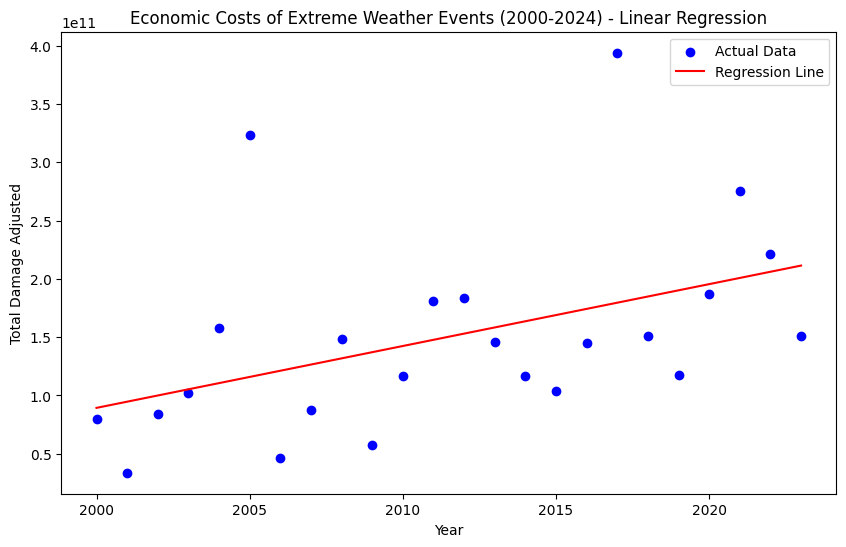

In [12]:
# Create the plot for the period 2000-2024
plt.figure(figsize=(10, 6))

# Scatter plot of the actual data for 2000-2024
plt.scatter(x_filtered, y_filtered, color='blue', label='Actual Data')

# Plot the regression line for 2000-2024
plt.plot(x_filtered, slope * x_filtered + intercept, color='red', label='Regression Line')
plt.title("Economic Costs of Extreme Weather Events (2000-2024) - Linear Regression")
plt.xlabel("Year")
plt.ylabel("Total Damage Adjusted")
plt.legend()
plt.show()


Insured Damage, Adjusted

In [ ]:
# Filter for extreme weather events
extreme_weather_events = ['Flood', 'Storm', 'Drought', 'Extreme temperature', 'Wildfire']
weather_data = data[data['Disaster Type'].isin(extreme_weather_events)]
economic_column = "Insured Damage, Adjusted ('000 US$)"
weather_data = weather_data[['Date', economic_column]]

weather_data[economic_column] = weather_data[economic_column] * 1000
weather_data.dropna(subset=[economic_column], inplace=True)

In [ ]:
weather_data.rename(columns={"Insured Damage, Adjusted ('000 US$)": "Insured Damage, Adjusted"}, inplace=True)

In [ ]:
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Aggregate total damage adjusted per year (or over your desired time period)
weather_data['Year'] = weather_data['Date'].dt.year
total_costs_per_year = weather_data.groupby('Year')['Insured Damage, Adjusted'].sum().reset_index()

# Remove NaN values
total_costs_per_year = total_costs_per_year.dropna()

In [16]:
# Define the independent (x) and dependent (y) variables for the filtered data
x_filtered = total_costs_per_year['Year'].values
y_filtered = total_costs_per_year["Insured Damage, Adjusted"].values

In [17]:
# Perform the regression on the filtered data
slope, intercept, r_value, p_value, std_err = linregress(x_filtered, y_filtered)

# Output the results of the regression
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

Slope: 1411808782.5515947
Intercept: -2796107821642.12
R-squared: 0.24031621736568554
P-value: 0.0013223624040838813


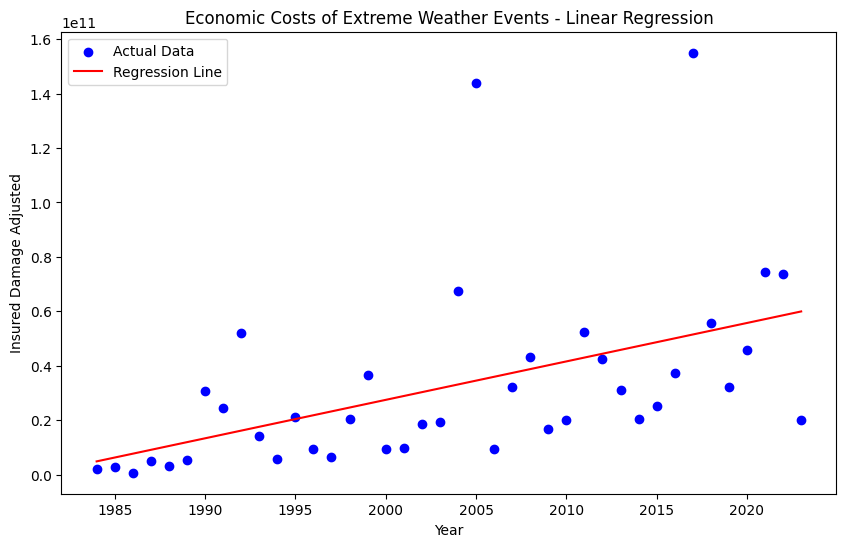

In [18]:
plt.figure(figsize=(10, 6))

plt.scatter(x_filtered, y_filtered, color='blue', label='Actual Data')
plt.plot(x_filtered, slope * x_filtered + intercept, color='red', label='Regression Line')
plt.title("Economic Costs of Extreme Weather Events - Linear Regression")
plt.xlabel("Year")
plt.ylabel("Insured Damage Adjusted")
plt.legend()
plt.show()

In [19]:
# Filter the data for the years between 2000 and 2024
filtered_data = total_costs_per_year[(total_costs_per_year['Year'] >= 2000) & (total_costs_per_year['Year'] <= 2024)]

# Define the independent (x) and dependent (y) variables for the filtered data
x_filtered = filtered_data['Year'].values
y_filtered = filtered_data["Insured Damage, Adjusted"].values

In [20]:
# Perform the regression on the filtered data
slope, intercept, r_value, p_value, std_err = linregress(x_filtered, y_filtered)

# Output the results of the regression
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")


Slope: 1297956950.4347825
Intercept: -2566820333382.8984
R-squared: 0.0588793629751195
P-value: 0.2532636536768073


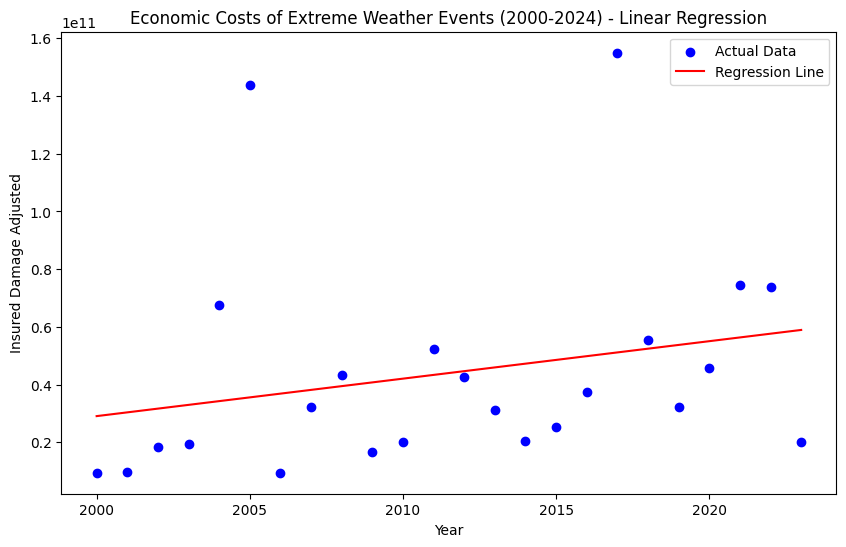

In [21]:
# Create the plot for the period 2000-2024
plt.figure(figsize=(10, 6))
plt.scatter(x_filtered, y_filtered, color='blue', label='Actual Data')
plt.plot(x_filtered, slope * x_filtered + intercept, color='red', label='Regression Line')
plt.title("Economic Costs of Extreme Weather Events (2000-2024) - Linear Regression")
plt.xlabel("Year")
plt.ylabel("Insured Damage Adjusted")
plt.legend()
plt.show()
